<a href="https://colab.research.google.com/github/simonsavine/phasetype/blob/main/markov_chain_simulation_discrete_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Helper functions

In [3]:
def is_square(R):
  shape = np.shape(R)

  if len(shape) != 2:
    return False

  return shape[0] == shape[1]


def is_proba_vector(P):
  if np.any(P < 0):
    return False

  return np.isclose(np.sum(P),1)

In [4]:
def is_transition_matrix(R):
  shape = np.shape(R)

  if not is_square(R):
    return False

  if shape[0] != shape[1]:
    return False

  n=shape[0]
  for i in range(n):
    if not is_proba_vector(R[:, i]):
      return False

  return True

In [5]:
def is_diagonalizable(R):
  if not is_square(R):
    return False

  ls, V = np.linalg.eig(R)

  return np.abs(np.linalg.det(V)) > 1e-6

In [6]:
def make_random_transition_matrix(n, diagonalizable=True):
  R = np.random.random((n, n))

  for i in range(n):
    R[:, i] /= np.sum(R[:, i])

  if diagonalizable:
    return R

  if not is_diagonalizable(R):
    return make_random_transition_matrix(n, True)


In [7]:
# End of helper functions

In [9]:
class MarkovChain:

  def __init__(self, R):

    assert is_transition_matrix(R), 'not a transition matrix'
    assert is_diagonalizable(R), 'not a diagonalizable matrix'

    self.n = np.shape(R)[0]
    self.R = R
    self.ls, self.V = np.linalg.eig(R)

    self.invV = np.linalg.inv(self.V)

  def calc_Rm(self, m=1):
    r_power_m = self.V @ np.diag(self.ls ** m) @ self.invV if m > 1 else self.R
    # dump (numerical) imaginary part, eigenvalues of stochastic matrices are always real
    return np.real(r_power_m)

  # Calculate Pi+m knowing Pi
  def calc_probas(self, Pi, m=1):
    return self.calc_Rm(m) @ Pi

  # Calculate Pr(Xi+m | Xi = k)
  def calc_probas_definitestate(self, k, m=1):
    return self.calc_Rm(m) [:, k]

  def sample_path(self, m, X0):
    x = X0
    xs=[X0]

    for _ in range(1, m):
      ps = self.calc_probas_definitestate(x)
      x = np.random.choice(self.n, p=ps)
      xs.append(x)

    return np.array(xs)

  def sample_paths(self, m, X0, M):
    paths = []
    for _ in range(M):
      paths.append(self.sample_path(m, X0))

    return np.array(paths)



In [10]:
# test our Markov chain

In [35]:
n = 5
R = make_random_transition_matrix(n)
R

array([[0.12348094, 0.14429833, 0.30013867, 0.32778726, 0.15468374],
       [0.03279475, 0.26471474, 0.19745055, 0.26479528, 0.01147632],
       [0.41053254, 0.17092451, 0.22318544, 0.21807703, 0.30811559],
       [0.07149915, 0.24042775, 0.25665002, 0.01428643, 0.16540378],
       [0.36169262, 0.17963467, 0.02257532, 0.17505399, 0.36032056]])

In [36]:
np.sum(R, axis=0)

array([1., 1., 1., 1., 1.])

In [37]:
chain = MarkovChain(R)

In [38]:
# around 15sec for 10k paths over 50 steps

m = 50
M = 10000
paths = chain.sample_paths(m = m, X0 = 0, M = M)

In [39]:
first_path = paths[0, :]
assert len(first_path) == m
first_path

array([0, 2, 0, 4, 3, 4, 1, 4, 4, 2, 0, 2, 0, 4, 2, 3, 1, 1, 2, 0, 2, 3,
       1, 4, 2, 2, 1, 0, 2, 2, 0, 2, 3, 0, 2, 0, 2, 1, 2, 0, 4, 4, 2, 0,
       0, 2, 3, 0, 2, 0])

In [40]:
final_states = paths[:, -1]
assert len(final_states) == M
final_states

array([0, 2, 4, ..., 4, 0, 2])

In [41]:
states, counts = np.unique(final_states, return_counts=True)
freqs = counts / np.sum(counts)

In [42]:
freqs

array([0.2023, 0.1446, 0.2784, 0.16  , 0.2147])

In [43]:
probas = chain.calc_probas_definitestate(0, m - 1)

Text(0.5, 1.0, 'state probabilities at time step 50')

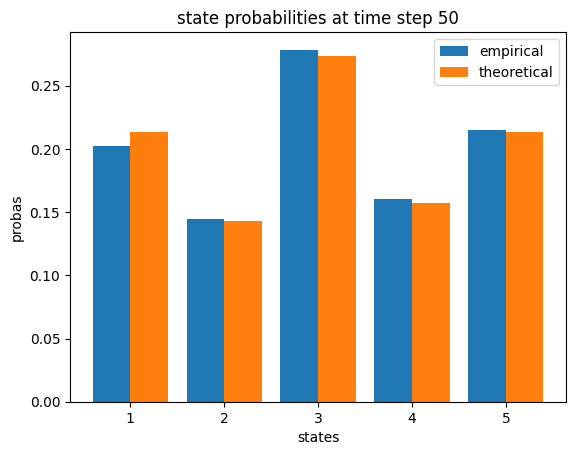

In [47]:
plt.bar(states + 0.8, freqs, 0.4, label = 'empirical')
plt.bar(states + 1.2, probas, 0.4, label = 'theoretical')
plt.legend()
plt.xlabel("states")
plt.ylabel("probas")
plt.title("state probabilities at time step 50")
